In [1]:
# 원래 사용하던 numpy 버전 -> 1.26.4 -> 최신버전 tensorflow 지원버전
# UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
#   warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

In [2]:
import sys
print(sys.version)

3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x2389a929700>)

In [5]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [6]:
data

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,neutral,Rinkuskiai's beer sales fell by 6.5 per cent t...,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,negative,Net sales of the Paper segment decreased to EU...,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [7]:
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
data[:5]

,labels,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [8]:
del data['kor_sentence']

In [9]:
data[:5]

,labels,sentence
0,0,"According to Gran, the company has no plans to..."
1,0,Technopolis plans to develop in stages an area...
2,2,The international electronic industry company ...
3,1,With the new production plant the company woul...
4,1,According to the company's updated strategy fo...


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   labels    4846 non-null   int64 
 1   sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [11]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [12]:
print('sentence 열의 유니크한 값 :',data['sentence'].nunique())

sentence 열의 유니크한 값 : 4838


In [13]:
duplicate = data[data.duplicated()]

In [14]:
duplicate

,labels,sentence
1099,0,The issuer is solely responsible for the conte...
1416,0,The report profiles 614 companies including ma...
2396,0,Ahlstrom's share is quoted on the NASDAQ OMX H...
2567,0,SSH Communications Security Corporation is hea...
3094,0,Proha Plc ( Euronext :7327 ) announced today (...
3206,0,The company serves customers in various indust...


In [15]:
# 중복 제거
data.drop_duplicates(subset=['sentence'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4838


<AxesSubplot:>

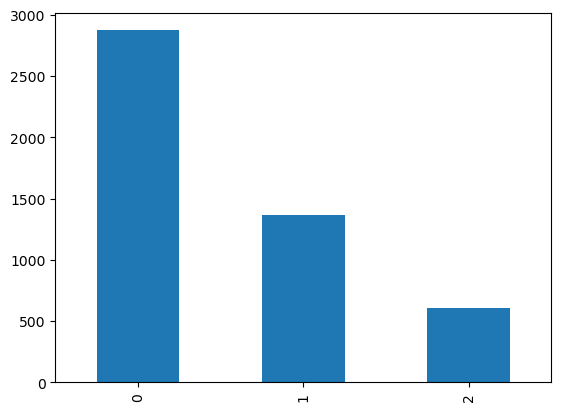

In [16]:
data['labels'].value_counts().plot(kind='bar')

In [17]:
print('레이블의 분포')
print(data.groupby('labels').size().reset_index(name='count'))

레이블의 분포
   labels  count
0       0   2872
1       1   1362
2       2    604


In [18]:
print(f'중립의 비율 = {round(data["labels"].value_counts()[0]/len(data) * 100,3)}%')
print(f'긍정의 비율 = {round(data["labels"].value_counts()[1]/len(data) * 100,3)}%')
print(f'부정의 비율 = {round(data["labels"].value_counts()[2]/len(data) * 100,3)}%')

중립의 비율 = 59.363%
긍정의 비율 = 28.152%
부정의 비율 = 12.484%


In [19]:
data

,labels,sentence
0,0,"According to Gran, the company has no plans to..."
1,0,Technopolis plans to develop in stages an area...
2,2,The international electronic industry company ...
3,1,With the new production plant the company woul...
4,1,According to the company's updated strategy fo...
...,...,...
4841,2,LONDON MarketWatch -- Share prices ended lower...
4842,0,Rinkuskiai's beer sales fell by 6.5 per cent t...
4843,2,Operating profit fell to EUR 35.4 mn from EUR ...
4844,2,Net sales of the Paper segment decreased to EU...


In [20]:
X_data = data['sentence']
y_data = data['labels']
print('본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 4838
레이블의 개수: 4838


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [22]:
X_train

2500    KONE is listed on the Nordic Exchange in Helsi...
4169    Among the Scandinavian companies present in St...
4241    The authorisation is in force until the end of...
3239    The energy shot is packed in a 100-millilitre ...
1723    HELSINKI (Thomson Financial)- Kemira GrowHow s...
                              ...                        
3746    Stora Enso's business in North America has ann...
2175    Pretax profit totalled EUR 2.0 mn, compared to...
4535    Based on the first quarter result, existing or...
2331    The shops are located in the capital region an...
375     The company said that its investments in the n...
Name: sentence, Length: 3870, dtype: object

In [23]:
y_train

2500    0
4169    0
4241    0
3239    0
1723    1
       ..
3746    0
2175    1
4535    2
2331    0
375     1
Name: labels, Length: 3870, dtype: int64

In [24]:
print('훈련 샘플의 개수 :', len(X_train))
print('테스트 샘플의 개수 :', len(X_test))

훈련 샘플의 개수 : 3870
테스트 샘플의 개수 : 968


In [25]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 59.354%
긍정 = 28.165%
부정 = 12.481%


In [26]:
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
중립 = 59.401%
긍정 = 28.099%
부정 = 12.5%


In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[981, 9, 587, 12, 1, 249, 196, 3, 70], [982, 1, 1397, 99, 794, 3, 350, 380, 9, 60, 1561, 1, 254, 1049, 4468, 59, 4469, 263, 3, 1, 1143, 2, 2435, 90, 1050, 4, 1144, 105, 161, 254, 4470], [1, 3088, 9, 3, 2025, 1051, 1, 121, 2, 1, 365, 186, 351, 454, 4, 4471, 1, 3088, 5, 624, 407, 66, 852, 17, 1, 351, 454, 472, 12, 216, 41, 53], [1, 222, 2436, 9, 3089, 3, 6, 269, 4472, 3090, 15, 6, 4473, 983], [70, 984, 80, 503, 4474, 1398, 162, 29, 3, 14, 65, 52, 266, 12, 705, 26, 985, 3, 14, 2437, 48, 3, 352, 59, 9, 2438, 1745, 217, 1, 65, 52]]
[[38, 2, 1, 2636, 1097, 17, 1, 723, 259, 19, 6, 277, 3045, 9, 2512, 2, 19, 4061], [451, 4453, 33, 687, 3, 2149, 3, 1, 1440, 2, 4453, 284, 4, 9, 106, 2, 451, 153, 504, 394, 243, 521, 3, 1, 686, 2398, 534], [1, 883, 9, 1451, 24, 8596, 26, 338, 853, 4, 64, 55, 3, 35], [1, 50, 60, 16, 6, 541, 175, 397, 3, 95, 1234, 7949], [3, 376, 981, 165, 6, 142, 31, 379, 81, 7, 1, 2753]]


In [28]:
# tokenizer.word_index

In [29]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

9348


본문의 최대 길이 : 302
본문의 평균 길이 : 125.91602067183463


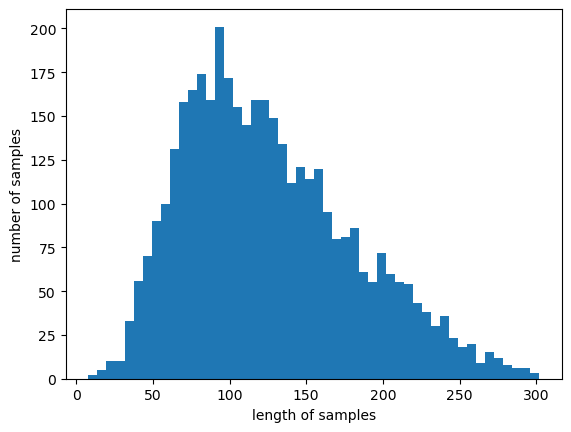

In [30]:
print('본문의 최대 길이 :',max(len(sent) for sent in X_train))
print('본문의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
max_len = 302

In [32]:
# X_train_encoded

In [33]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [34]:
X_train_encoded.shape

(3870, 302)

In [35]:
X_train_encoded[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [36]:
X_test_encoded.shape

(968, 302)

In [37]:
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [38]:
# loaded_model = load_model('best_model.h5')
# print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_encoded, y_test)[1]))

In [39]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [40]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [41]:
X_train_encoded.shape

(3870, 302)

In [42]:
y_train.shape

(3870,)

In [43]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train_encoded), torch.from_numpy(y_train.values))
valid_data = TensorDataset(torch.from_numpy(X_test_encoded), torch.from_numpy(y_test.values))

# dataloaders
batch_size = 32

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [44]:
len(iter(train_loader))

121

In [45]:
next(iter(train_loader))[0].shape

torch.Size([32, 302])

In [46]:
next(iter(train_loader))[1].shape

torch.Size([32])

In [47]:
valid_loader

In [48]:
input_size = 64
hidden_size = 64
num_layers = 2
num_classes = 3

In [49]:
# 설정값
# data_dim = 5
# hidden_dim = 10 
# output_dim = 1 
# learning_rate = 0.01
# nb_epochs = 100

class myModel(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, vocab_size, embedding_dim, hidden_units, num_layers, num_classes):
        super(myModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_units, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_units, num_classes)
    
    def forward(self, x):
        embedded = self.embedding(x)
        embedded.to(device)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_units).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_units).to(x.device)
        out, _ = self.lstm(embedded, (h0, c0))
        out = self.fc(out[:, -1, :])
        
        return out, h0

In [50]:
model = myModel(vocab_size, input_size, hidden_size, num_layers, num_classes)

In [51]:
model

myModel(
  (embedding): Embedding(9348, 64)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [53]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [54]:
epochs = 15
valid_loss_min = np.Inf

train_loss = torch.zeros(epochs)
valid_loss = torch.zeros(epochs)

train_acc = torch.zeros(epochs)
valid_acc = torch.zeros(epochs)

for e in tqdm(range(0, epochs)):
    model.train()
    # initialize hidden state 
    # h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        labels = labels.to(device)
        
        model.zero_grad()
        output, h = model(inputs)
        # calculate the loss and perform backprop
        output, h = output.to(device), h.to(device)
        loss = criterion(output.squeeze(), labels.long())
        train_loss[e] += loss.item()
        loss.backward()
        
        # calculating accuracy
        # accuracy = acc(output,labels)
        ps = F.softmax(output, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
        
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        # nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)

    
    model.eval()
    for inputs, labels in valid_loader:
        labels = labels.to(device)

        output, val_h = model(inputs)
        output, val_h = output.to(device), val_h.to(device)
        val_loss = criterion(output.squeeze(), labels.long())
        valid_loss[e] += val_loss.item()

        ps = F.softmax(output, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    valid_loss[e] /= len(valid_loader)
    valid_acc[e] /= len(valid_loader)
    
    print(f'Epoch {e+1}') 
    print(f'train_loss : {train_loss[e]}, val_loss : {valid_loss[e]}')
    print(f'train_accuracy : {train_acc[e]*100}, val_accuracy : {valid_acc[e]*100}')
    if valid_loss[e] <= valid_loss_min:
        torch.save(model, 'model.pth')
        torch.save(model.state_dict(), 'model_state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss[e]))
        valid_loss_min = valid_loss[e]
    print(25*'==')

  7%|█████▌                                                                             | 1/15 [00:53<12:29, 53.52s/it]

Epoch 1
train_loss : 0.8997794389724731, val_loss : 0.8209075927734375
train_accuracy : 61.3670768737793, val_accuracy : 64.51612854003906
Validation loss decreased (inf --> 0.820908).  Saving model ...


 13%|███████████                                                                        | 2/15 [01:47<11:40, 53.91s/it]

Epoch 2
train_loss : 0.7714381814002991, val_loss : 0.7659530639648438
train_accuracy : 66.53064727783203, val_accuracy : 68.04434967041016
Validation loss decreased (0.820908 --> 0.765953).  Saving model ...


 20%|████████████████▌                                                                  | 3/15 [02:45<11:10, 55.88s/it]

Epoch 3
train_loss : 0.685615062713623, val_loss : 0.7505661845207214
train_accuracy : 71.45144653320312, val_accuracy : 70.36289978027344
Validation loss decreased (0.765953 --> 0.750566).  Saving model ...


 27%|██████████████████████▏                                                            | 4/15 [03:48<10:44, 58.62s/it]

Epoch 4
train_loss : 0.5851908326148987, val_loss : 0.7609384059906006
train_accuracy : 75.2927017211914, val_accuracy : 69.45565032958984


 33%|███████████████████████████▋                                                       | 5/15 [04:50<09:56, 59.63s/it]

Epoch 5
train_loss : 0.4779610335826874, val_loss : 0.743162989616394
train_accuracy : 80.95902252197266, val_accuracy : 70.26210021972656
Validation loss decreased (0.750566 --> 0.743163).  Saving model ...


 40%|█████████████████████████████████▏                                                 | 6/15 [05:46<08:45, 58.35s/it]

Epoch 6
train_loss : 0.350305438041687, val_loss : 0.8391452431678772
train_accuracy : 87.65323638916016, val_accuracy : 68.6491928100586


 47%|██████████████████████████████████████▋                                            | 7/15 [06:42<07:41, 57.63s/it]

Epoch 7
train_loss : 0.25400853157043457, val_loss : 0.9098711609840393
train_accuracy : 91.6804428100586, val_accuracy : 70.66532135009766


 53%|████████████████████████████████████████████▎                                      | 8/15 [07:35<06:34, 56.36s/it]

Epoch 8
train_loss : 0.17363378405570984, val_loss : 1.028869390487671
train_accuracy : 94.5230712890625, val_accuracy : 69.55644989013672


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [08:38<05:49, 58.20s/it]

Epoch 9
train_loss : 0.13501788675785065, val_loss : 1.0865312814712524
train_accuracy : 95.63360595703125, val_accuracy : 72.17742156982422


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [09:44<05:04, 60.89s/it]

Epoch 10
train_loss : 0.09767162054777145, val_loss : 1.2160264253616333
train_accuracy : 97.10743713378906, val_accuracy : 69.85887145996094


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [10:44<04:02, 60.53s/it]

Epoch 11
train_loss : 0.07000042498111725, val_loss : 1.2331578731536865
train_accuracy : 97.85639953613281, val_accuracy : 69.55644989013672


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [11:45<03:02, 60.70s/it]

Epoch 12
train_loss : 0.05131945386528969, val_loss : 1.2488735914230347
train_accuracy : 98.55371856689453, val_accuracy : 72.07661437988281


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [12:49<02:03, 61.57s/it]

Epoch 13
train_loss : 0.04576300084590912, val_loss : 1.293190360069275
train_accuracy : 98.70867919921875, val_accuracy : 71.7741928100586


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [13:53<01:02, 62.25s/it]

Epoch 14
train_loss : 0.03935620188713074, val_loss : 1.3073315620422363
train_accuracy : 99.06852722167969, val_accuracy : 73.38710021972656


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [14:56<00:00, 59.79s/it]

Epoch 15
train_loss : 0.03951215744018555, val_loss : 1.4721934795379639
train_accuracy : 98.83436584472656, val_accuracy : 67.54032135009766
